In [1]:
#Importing the required modules and general setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleAdiabatic
from galpy.df import quasiisothermaldf
from galpy.util.bovy_coords import *
from scipy.integrate import dblquad
import sys
sys.path.append('..')
from tools.tools import *
import time
import matplotlib.pyplot as plt
%pylab inline

#Importing qdf load data
samples_qdf_rect = np.load('../mock_data/qdf/data/sampleV_at_(0.0,0.0,0.0)_epsilon=0.5_rect.npy')


print('#stars', len(samples_qdf_rect))
print('min/max/mean (x)', min(samples_qdf_rect[:,0]), max(samples_qdf_rect[:,0]), np.mean(samples_qdf_rect[:,0]))
print('min/max/mean (y)', min(samples_qdf_rect[:,1]), max(samples_qdf_rect[:,1]), np.mean(samples_qdf_rect[:,1]))
print('min/max/mean (z)', min(samples_qdf_rect[:,2]), max(samples_qdf_rect[:,2]), np.mean(samples_qdf_rect[:,2]))
print('min/max/mean (vx)', min(samples_qdf_rect[:,3]), max(samples_qdf_rect[:,3]), np.mean(samples_qdf_rect[:,3]))
print('min/max/mean (vy)', min(samples_qdf_rect[:,4]), max(samples_qdf_rect[:,4]), np.mean(samples_qdf_rect[:,4]))
print('min/max/mean (vz)', min(samples_qdf_rect[:,5]), max(samples_qdf_rect[:,5]), np.mean(samples_qdf_rect[:,5]))
print()

#stack samples for KDE
x, y, z = (samples_qdf_rect[:,0], samples_qdf_rect[:,1], samples_qdf_rect[:,2])
vx, vy, vz = (samples_qdf_rect[:,3], samples_qdf_rect[:,4], samples_qdf_rect[:,5])
samples_qdf = np.stack((x, y, z, vx, vy, vz), axis=1)


Populating the interactive namespace from numpy and matplotlib
#stars 1699708
min/max/mean (x) -8.79960923614 -7.80090011781 -8.28941027929
min/max/mean (y) -0.499538706611 0.499568261463 0.0024822784534
min/max/mean (z) -0.472240992289 0.525186432321 0.0205541620714
min/max/mean (vx) -229.133450157 225.798605872 -0.064926005656
min/max/mean (vy) -300.740537201 -18.6579577359 -200.864642685
min/max/mean (vz) -78.6318475051 79.4952977672 -0.00151810605736



In [6]:
#docstring deleted to keep short
def generate_KDE(inputs, ker):

    #Scaling velocities with standard deviation
    inputs_std = np.nanstd(inputs, axis=0)
    inputs = inputs/inputs_std
    
    #Optimizing bandwidth in terms of Scott's Rule of Thumb
    shape_string = str(inputs.shape)
    objects, parameters = shape_string.split(', ')
    N_string = objects[1:]
    N = int(N_string)
    IQR = iqr(inputs)
    A = min(np.std(inputs), IQR/1.34)
    bw = 3  * 1.059 * A * N ** (-1/5.)
    
    #Fit data points to selected kernel and bandwidth
    kde = KernelDensity(kernel=ker, bandwidth=bw).fit(inputs)  
    
    def input_KDE(samples):

        #To correct the type of information from other functions into acceptable input
        #samples = np.array([samples])
        
        #Scaling samples with standard deviation
        samples = samples/inputs_std
        
        #Get the log density for selected samples and apply exponential to get normal probabilities
        log_dens = kde.score_samples(samples)
        dens = np.exp(log_dens)
        
        #Return a 1xQ array of normal probabilities for the selected sample
        return dens
    
    #Return a black box function for sampling
    return input_KDE

In [3]:
kde_qdf_scott1 = generate_KDE(samples_qdf, 'epanechnikov')

In [5]:
kde_qdf_scott2 = generate_KDE(samples_qdf, 'epanechnikov')

In [7]:
kde_qdf_scott3 = generate_KDE(samples_qdf, 'epanechnikov')

In [11]:
#input values for velocities (vR, vT, vz)

v_input = np.linspace(-200, 400, 100)


In [16]:
# 2x SCOTTS RULE OF THUMB 
# -----------------
# Integrate over vR
# -----------------

def kde_qdf_cyl_vR(vT, vz, R, phi, z, vR):
    evaluate_at = np.array(cyl_to_rect(R, vR, vT, z, vz, phi))
    evaluation = kde_qdf_scott2(evaluate_at)
    return evaluation

def integrate_over_vR(kde_qdf_scott2, vR): #bounds of vT = [0, 300], bounds of vz = [-100, 100]
    print ("Evaluating at vR =", vR)
    return dblquad(kde_qdf_cyl_vR, 0, 300, -100, 100, args=([8.3, 3.14, 0., vR]), epsabs=0.001)  # args=(R, phi, z, vR)

vR_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vT from [0, 300] and vz from [-100, 100].")
print("KDE Evaluations along vR from [-200, 400] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vR_output[counter - 1], error = integrate_over_vR(kde_qdf_scott2, v)
    print("Value:", vR_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vT
# -----------------

def kde_qdf_cyl_vT(vR, vz, R, phi, z, vT):
    evaluate_at = np.array(cyl_to_rect(R, vR, vT, z, vz, phi))
    evaluation = kde_qdf_scott2(evaluate_at)
    return evaluation

def integrate_over_vT(kde_qdf_scott2, vT): #bounds of vR = [-100, 100], bounds of vz = [-100, 100]
    print ("Evaluating at vT =", vT)
    return dblquad(kde_qdf_cyl_vT, -100, 100, -100, 100, args=([8.3, 3.14, 0., vT]), epsabs=0.01)  # args=(R, phi, z, vR)

vT_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vz from [-100, 100].")
print("KDE Evaluations along vT from [-200, 400] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vT_output[counter - 1], error = integrate_over_vT(kde_qdf_scott2, v)
    print("Value:", vT_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vz
# -----------------

def kde_qdf_cyl_vz(vR, vT, R, phi, z, vz):
    evaluate_at = np.array(cyl_to_rect(R, vR, vT, z, vz, phi))
    evaluation = kde_qdf_scott2(evaluate_at)
    return evaluation

def integrate_over_vz(kde_qdf_scott2, vz): #bounds of vR = [-100, 100], bounds of vT = [0, 300]
    print ("Evaluating at vz =", vz)
    return dblquad(kde_qdf_cyl_vz, -100, 100, 0, 300, args=([8.3, 3.14, 0., vz]), epsabs=0.001)  # args=(R, phi, z, vR)

vz_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vT from [0, 300].")
print("KDE Evaluations along vz from [-200, 400] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vz_output[counter - 1], error = integrate_over_vz(kde_qdf_scott2, v)
    print("Value:", vz_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()




With R, phi, z = 8.3, 3.14, 0., integrating over vT from [0, 300] and vz from [-100, 100].
KDE Evaluations along vR from [-200, 400] over 100 subintervals.

Evaluation: 1
Evaluating at vR = -200.0
Value: 3.71081660249e-12
Time to integrate: 0.44s
Time elapsed: 0.01 min

Evaluation: 2
Evaluating at vR = -193.93939393939394
Value: 5.17976142181e-12
Time to integrate: 0.57s
Time elapsed: 0.02 min

Evaluation: 3
Evaluating at vR = -187.87878787878788
Value: 6.26309729033e-12
Time to integrate: 0.46s
Time elapsed: 0.02 min

Evaluation: 4
Evaluating at vR = -181.8181818181818
Value: 7.91129797915e-12
Time to integrate: 0.46s
Time elapsed: 0.03 min

Evaluation: 5
Evaluating at vR = -175.75757575757575
Value: 0.000407703889216
Time to integrate: 0.44s
Time elapsed: 0.04 min

Evaluation: 6
Evaluating at vR = -169.6969696969697
Value: 0.00121106501095
Time to integrate: 0.46s
Time elapsed: 0.05 min

Evaluation: 7
Evaluating at vR = -163.63636363636363
Value: 0.00212842619768
Time to integrate: 0

Value: 2.58441480732e-12
Time to integrate: 0.44s
Time elapsed: 1.18 min

Evaluation: 67
Evaluating at vR = 200.0
Value: 4.38793122133e-12
Time to integrate: 0.42s
Time elapsed: 1.18 min

Evaluation: 68
Evaluating at vR = 206.06060606060606
Value: 4.15208398588e-12
Time to integrate: 0.14s
Time elapsed: 1.19 min

Evaluation: 69
Evaluating at vR = 212.12121212121212
Value: 3.45002652041e-12
Time to integrate: 0.42s
Time elapsed: 1.19 min

Evaluation: 70
Evaluating at vR = 218.1818181818182
Value: 1.30260734208e-12
Time to integrate: 0.43s
Time elapsed: 1.2 min

Evaluation: 71
Evaluating at vR = 224.24242424242425
Value: 4.59374251108e-13
Time to integrate: 0.38s
Time elapsed: 1.21 min

Evaluation: 72
Evaluating at vR = 230.3030303030303
Value: 0.0
Time to integrate: 0.08s
Time elapsed: 1.21 min

Evaluation: 73
Evaluating at vR = 236.36363636363637
Value: 0.0
Time to integrate: 0.08s
Time elapsed: 1.21 min

Evaluation: 74
Evaluating at vR = 242.42424242424244
Value: 0.0
Time to integrate

Value: 3.43239180738e-11
Time to integrate: 0.72s
Time elapsed: 0.07 min

Evaluation: 38
Evaluating at vT = 24.24242424242425
Value: 4.23569638062e-11
Time to integrate: 0.79s
Time elapsed: 0.08 min

Evaluation: 39
Evaluating at vT = 30.30303030303031
Value: 0.000315043752095
Time to integrate: 0.84s
Time elapsed: 0.1 min

Evaluation: 40
Evaluating at vT = 36.363636363636374
Value: 0.00223528022997
Time to integrate: 0.92s
Time elapsed: 0.11 min

Evaluation: 41
Evaluating at vT = 42.424242424242436
Value: 0.0043435758513
Time to integrate: 0.99s
Time elapsed: 0.13 min

Evaluation: 42
Evaluating at vT = 48.48484848484847
Value: 0.00738961473997
Time to integrate: 1.08s
Time elapsed: 0.15 min

Evaluation: 43
Evaluating at vT = 54.54545454545453
Value: 0.0140856452952
Time to integrate: 1.16s
Time elapsed: 0.17 min

Evaluation: 44
Evaluating at vT = 60.60606060606062
Value: 0.0271078172328
Time to integrate: 4.18s
Time elapsed: 0.24 min

Evaluation: 45
Evaluating at vT = 66.66666666666669

Value: 0.0
Time to integrate: 0.08s
Time elapsed: 0.01 min

Evaluation: 5
Evaluating at vz = -175.75757575757575
Value: 0.0
Time to integrate: 0.08s
Time elapsed: 0.01 min

Evaluation: 6
Evaluating at vz = -169.6969696969697
Value: 0.0
Time to integrate: 0.09s
Time elapsed: 0.01 min

Evaluation: 7
Evaluating at vz = -163.63636363636363
Value: 0.0
Time to integrate: 0.09s
Time elapsed: 0.01 min

Evaluation: 8
Evaluating at vz = -157.57575757575756
Value: 0.0
Time to integrate: 0.09s
Time elapsed: 0.01 min

Evaluation: 9
Evaluating at vz = -151.5151515151515
Value: 0.0
Time to integrate: 0.09s
Time elapsed: 0.01 min

Evaluation: 10
Evaluating at vz = -145.45454545454544
Value: 0.0
Time to integrate: 0.09s
Time elapsed: 0.01 min

Evaluation: 11
Evaluating at vz = -139.39393939393938
Value: 0.0
Time to integrate: 0.09s
Time elapsed: 0.02 min

Evaluation: 12
Evaluating at vz = -133.33333333333331
Value: 0.0
Time to integrate: 0.09s
Time elapsed: 0.02 min

Evaluation: 13
Evaluating at vz = -

Value: 0.0
Time to integrate: 0.09s
Time elapsed: 0.57 min

Evaluation: 76
Evaluating at vz = 254.54545454545456
Value: 0.0
Time to integrate: 0.09s
Time elapsed: 0.57 min

Evaluation: 77
Evaluating at vz = 260.6060606060606
Value: 0.0
Time to integrate: 0.09s
Time elapsed: 0.57 min

Evaluation: 78
Evaluating at vz = 266.6666666666667
Value: 0.0
Time to integrate: 0.09s
Time elapsed: 0.57 min

Evaluation: 79
Evaluating at vz = 272.72727272727275
Value: 0.0
Time to integrate: 0.08s
Time elapsed: 0.57 min

Evaluation: 80
Evaluating at vz = 278.7878787878788
Value: 0.0
Time to integrate: 0.09s
Time elapsed: 0.57 min

Evaluation: 81
Evaluating at vz = 284.8484848484849
Value: 0.0
Time to integrate: 0.09s
Time elapsed: 0.58 min

Evaluation: 82
Evaluating at vz = 290.9090909090909
Value: 0.0
Time to integrate: 0.09s
Time elapsed: 0.58 min

Evaluation: 83
Evaluating at vz = 296.96969696969694
Value: 0.0
Time to integrate: 0.09s
Time elapsed: 0.58 min

Evaluation: 84
Evaluating at vz = 303.030

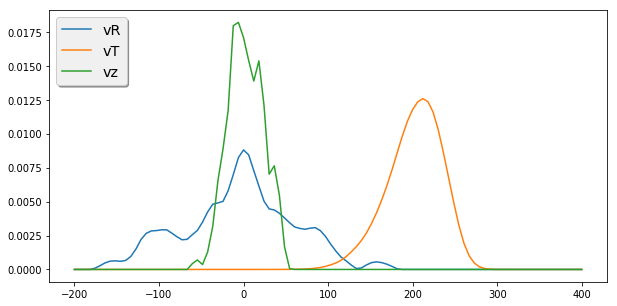

In [20]:
# 2*scotts rule of thumb
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(v_input, vR_output/np.sum(vR_output)/(v_input[1]-v_input[0]), label='vR') #normalized area to 1
ax.plot(v_input, vT_output/np.sum(vT_output)/(v_input[1]-v_input[0]), label='vT')
ax.plot(v_input, vz_output/np.sum(vz_output)/(v_input[1]-v_input[0]), label='vz')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('#F0F0F0')

In [ ]:
# 3*scotts rule of thumb
vs= np.linspace(-1,2,100)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(v_input, vR_output/np.sum(vR_output)/(v_input[1]-v_input[0]), label='vR') #normalized area to 1
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('#F0F0F0')

In [19]:
vT_output

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.30550292e-11,
         3.43239181e-11,   4.23569638e-11,   3.15043752e-04,
         2.23528023e-03,   4.34357585e-03,   7.38961474e-03,
         1.40856453e-02,   2.71078172e-02,   4.76255632e-02,
         7.43924297e-02,   1.10319844e-01,   1.75400813e-01,
         2.85351376e-01,